In [1]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, lubridate, zoo)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 15, repr.plot.height=12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "lubridate"  TRUE  
[7,] "zoo"        TRUE  


# NYT county level time series 
https://github.com/nytimes/covid-19-data

In [2]:
#%% check timestamp at https://github.com/nytimes/covid-19-data
df = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df[, d := anydate(date)]

In [3]:
setorder(df, state, county, date)
df[,  `:=`(
  cfr = deaths/cases,
  new_cases  = cases - shift(cases),
  new_deaths = deaths - shift(deaths)
), by = .(state, county)]
# clean up
df[ ,`:=`(new_deaths = ifelse(new_deaths < 0, 0, new_deaths),
          new_cases  = ifelse(new_cases < 0, 0, new_cases)
              )]
df = df[d >= "2020-03-01"]
rawvars = c("cases", "deaths", "new_cases", "new_deaths")

In [4]:
df[order(-date, -cases)][1:20]

date,county,state,fips,cases,deaths,d,cfr,new_cases,new_deaths
<chr>,<chr>,<chr>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>
2020-06-22,New York City,New York,NA,217487,21796,2020-06-22,0.10022,298,43
2020-06-22,Cook,Illinois,17031,87424,4423,2020-06-22,0.05059,247,19
2020-06-22,Los Angeles,California,6037,85942,3137,2020-06-22,0.03650,2545,17
2020-06-22,Nassau,New York,36059,41513,2683,2020-06-22,0.06463,34,0
2020-06-22,Suffolk,New York,36103,41010,2014,2020-06-22,0.04911,38,1
2020-06-22,Westchester,New York,36119,34556,1546,2020-06-22,0.04474,36,1
2020-06-22,Maricopa,Arizona,4013,31650,634,2020-06-22,0.02003,1514,2
2020-06-22,Miami-Dade,Florida,12086,26238,884,2020-06-22,0.03369,449,0
2020-06-22,Philadelphia,Pennsylvania,42101,25116,1553,2020-06-22,0.06183,275,0


In [5]:
fwrite(df, 'data/nyt_county_level.csv')

### Rolling Mean Function

In [6]:
rollmeaneR = function(df, 
                      smoothvars = rawvars,
                      grouping = c("state", "county"),
                      sm_k = 5){
    f = copy(df)
    setorderv(f, cols = c(grouping, 'd'))
    f[, paste0("rm", "_", smoothvars) := lapply(.SD, rollmean, k = sm_k, fill = NA, na.pad = T), 
       by = grouping, .SDcols = smoothvars]
    return(f)
}

# Nationwide 

In [7]:
npan = df[, lapply(.SD, sum, na.rm = T), by = .(d), .SDcols = rawvars]
npan[, gr := 1]
npan[, cfr := deaths/cases]
npan = rollmeaneR(npan, c(rawvars, 'cfr'), grouping = "gr")
npan[, day := weekdays(d)]
npan[, weekend := ifelse(day %in% c("Saturday", "Sunday"), 1, 0)]
npan[order(-d)][1:5]

d,cases,deaths,new_cases,new_deaths,gr,cfr,rm_cases,rm_deaths,rm_new_cases,rm_new_deaths,rm_cfr,day,weekend
<date>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2020-06-22,2322186,120346,31474,377,1,0.05182,NA,NA,NA,NA,NA,Monday,0
2020-06-21,2291735,119985,26583,279,1,0.05236,NA,NA,NA,NA,NA,Sunday,1
2020-06-20,2265360,119710,32091,552,1,0.05284,2263053,119533,30282,536.8,0.05283,Saturday,1
2020-06-19,2233395,119166,33050,729,1,0.05336,2233529,119010,29201,619.8,0.05330,Friday,0
2020-06-18,2202587,118457,28211,747,1,0.05378,2204972,118409,28915,720.6,0.05371,Thursday,0


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”


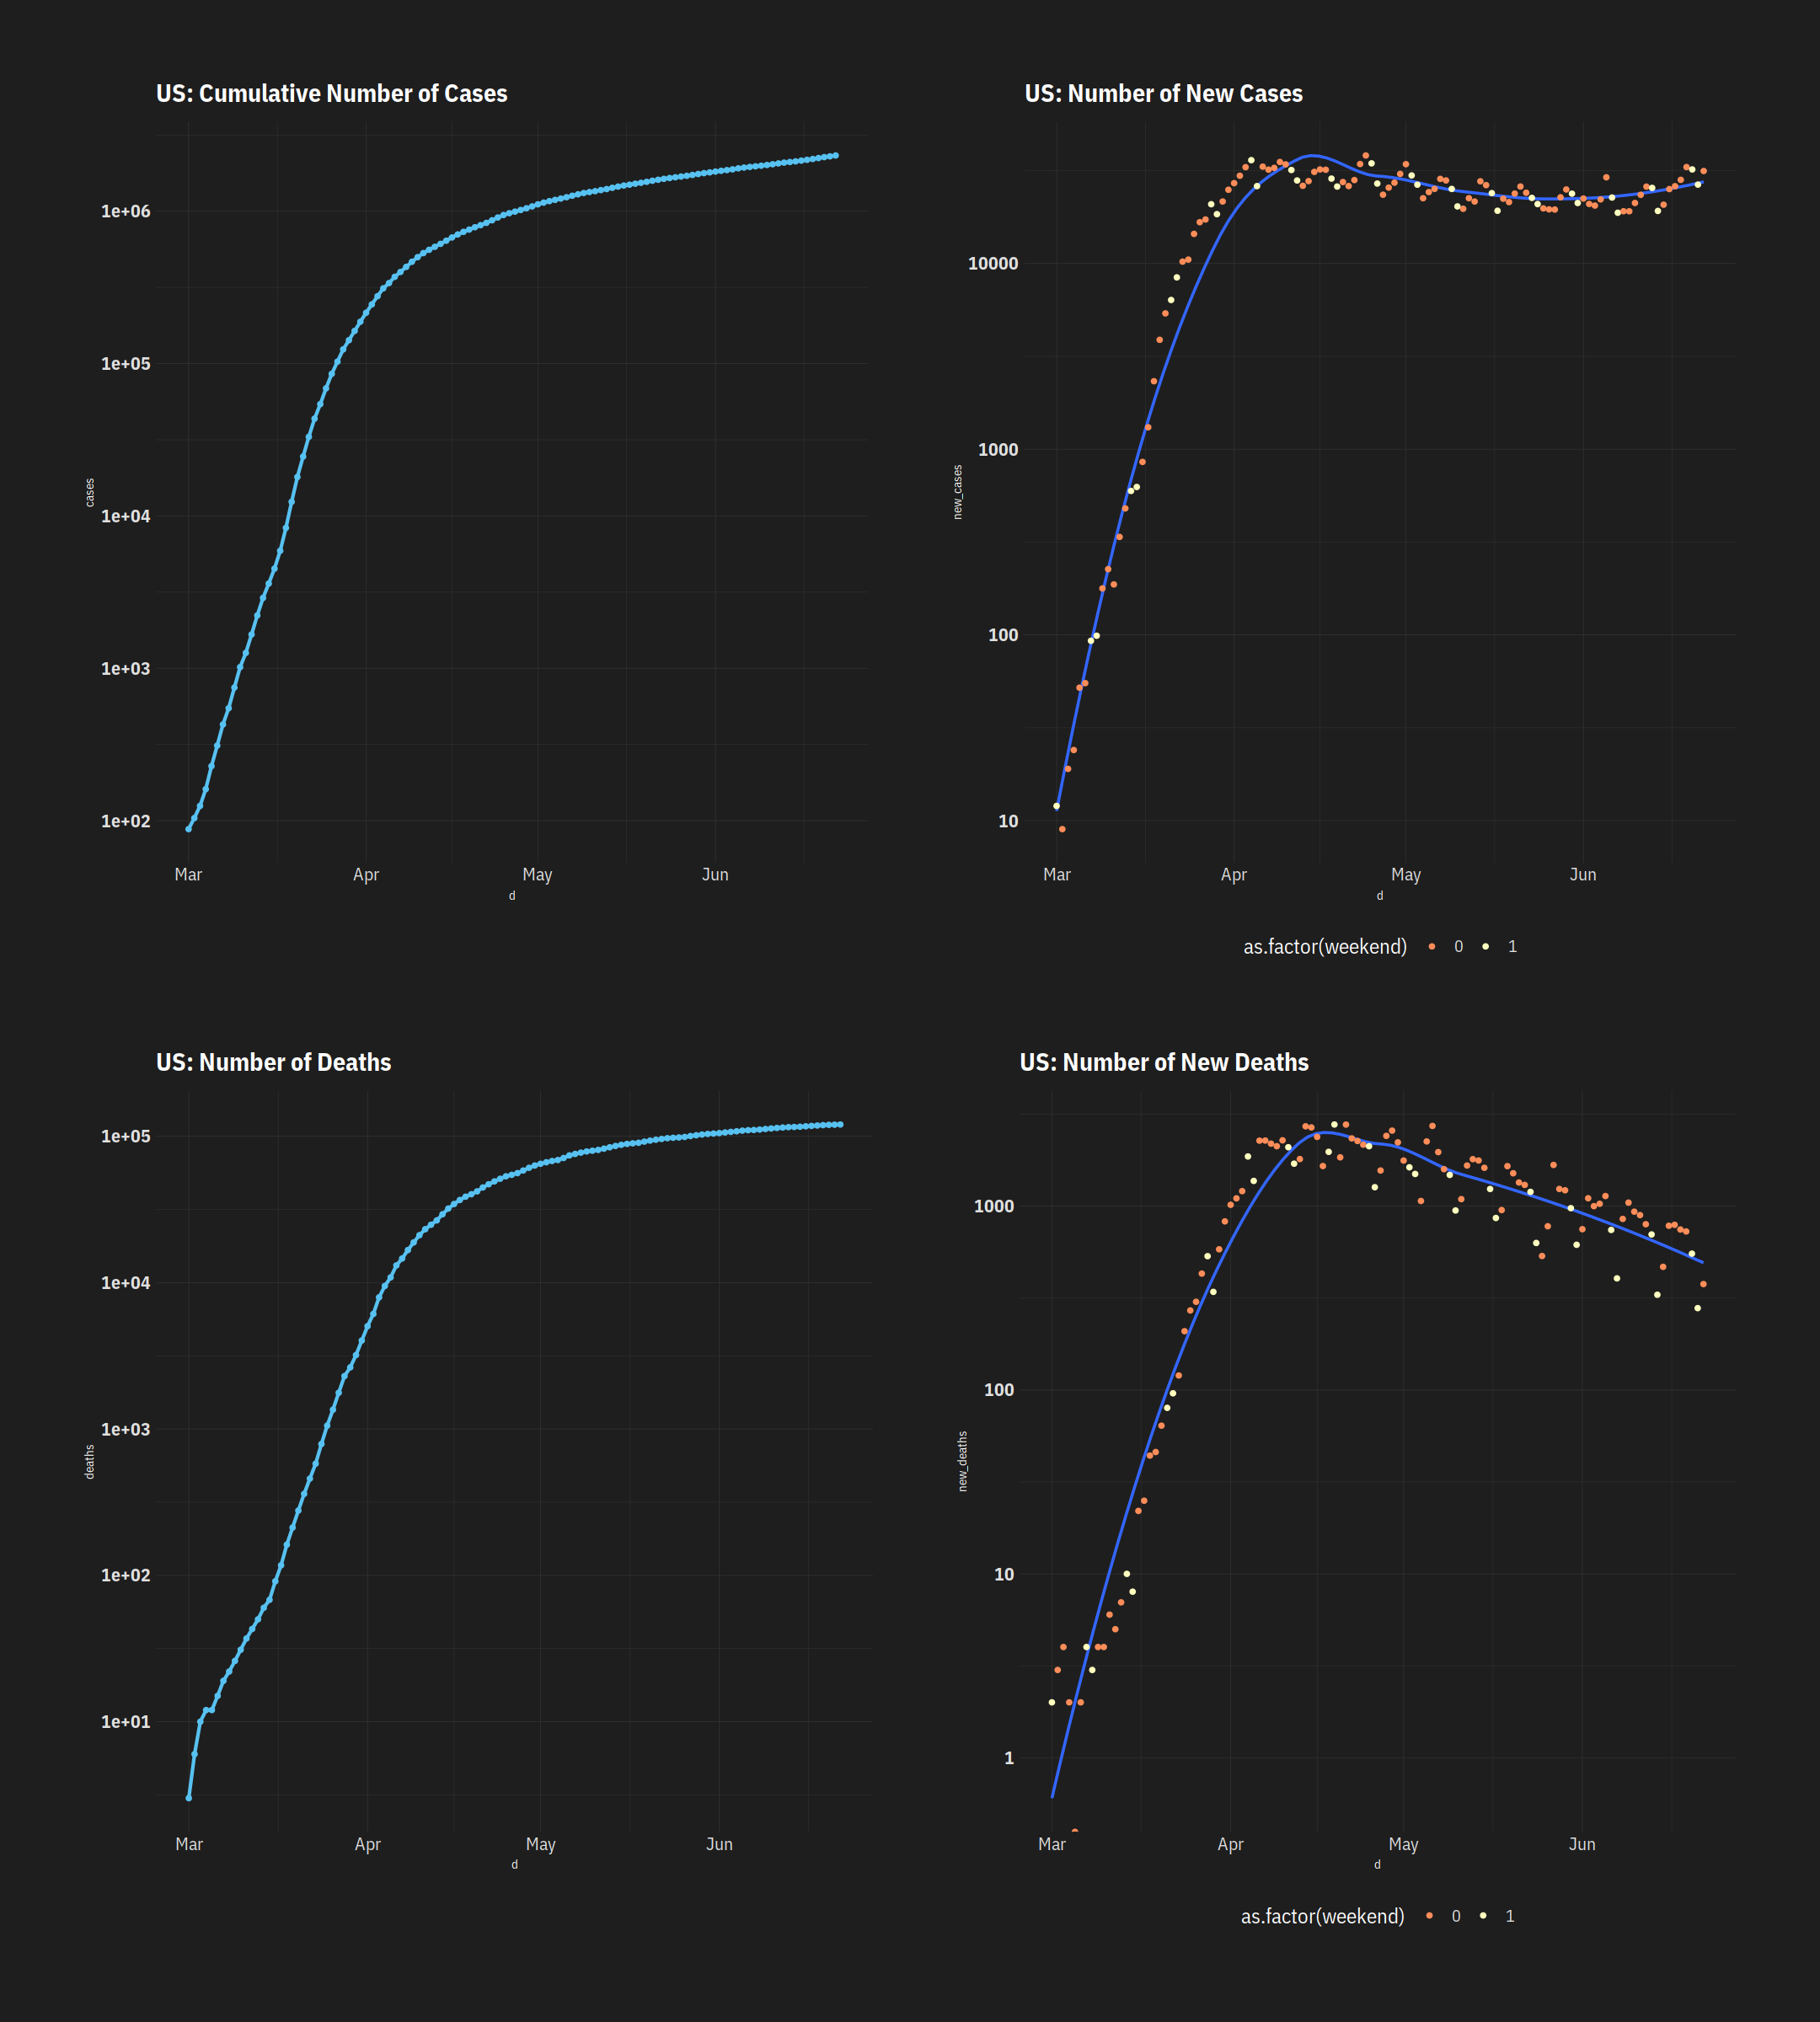

In [8]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(npan, aes(x = d, y = cases)) +
  geom_line(size = 1.2) + geom_point()+ 
  scale_y_log10() +
  ggtitle("US: Cumulative Number of Cases")

p11 = ggplot(npan, aes(x = d, y = new_cases)) +
#   geom_line(aes(y = rm_new_cases)) +
    geom_smooth(se = F) +
    geom_point(aes( colour = as.factor(weekend))) +
    scale_y_log10() +
    scale_colour_brewer(palette = "Spectral") + 
    ggtitle("US: Number of New Cases")

p2 = ggplot(npan, aes(x = d, y = deaths)) +
  geom_line(size = 1.2) + geom_point() +
  scale_y_log10() +
  ggtitle("US: Number of Deaths")

p22 = ggplot(npan, aes(x = d, y = new_deaths)) +
#   geom_line(aes(y = rm_new_deaths)) +
    geom_smooth(se = F) +
    geom_point(aes(colour = as.factor(weekend))) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") + 
    ggtitle("US: Number of New Deaths")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

In [9]:
options(repr.plot.width = 10, repr.plot.height=8)
nat_cfr = ggplot(npan[d>= "2020-03-15"], aes(x = d, y = cfr)) +
  geom_line(aes(y = rm_cfr)) + geom_point()+ 
  ggtitle("US: CFR")

## State Panel 

In [10]:
stpan = df[, lapply(.SD, sum, na.rm = T), by = .(state, d), .SDcols = rawvars]
(t10 = stpan[d == max(d)][order(-cases)][1:10])
stpan[, cfr := deaths/cases]
stpan = rollmeaneR(stpan, c(rawvars, 'cfr'), grouping = "state")

state,d,cases,deaths,new_cases,new_deaths
<chr>,<date>,<int>,<int>,<dbl>,<dbl>
New York,2020-06-22,393257,30934,555,50
California,2020-06-22,184620,5561,5814,44
New Jersey,2020-06-22,169415,12895,280,25
Illinois,2020-06-22,138615,6889,462,24
Texas,2020-06-22,119646,2213,4759,18
Massachusetts,2020-06-22,107210,7873,152,17
Florida,2020-06-22,100209,3172,2946,12
Pennsylvania,2020-06-22,86666,6475,642,3
Michigan,2020-06-22,68144,6101,273,7


Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 10 rows containing missing values (geom_smooth).”


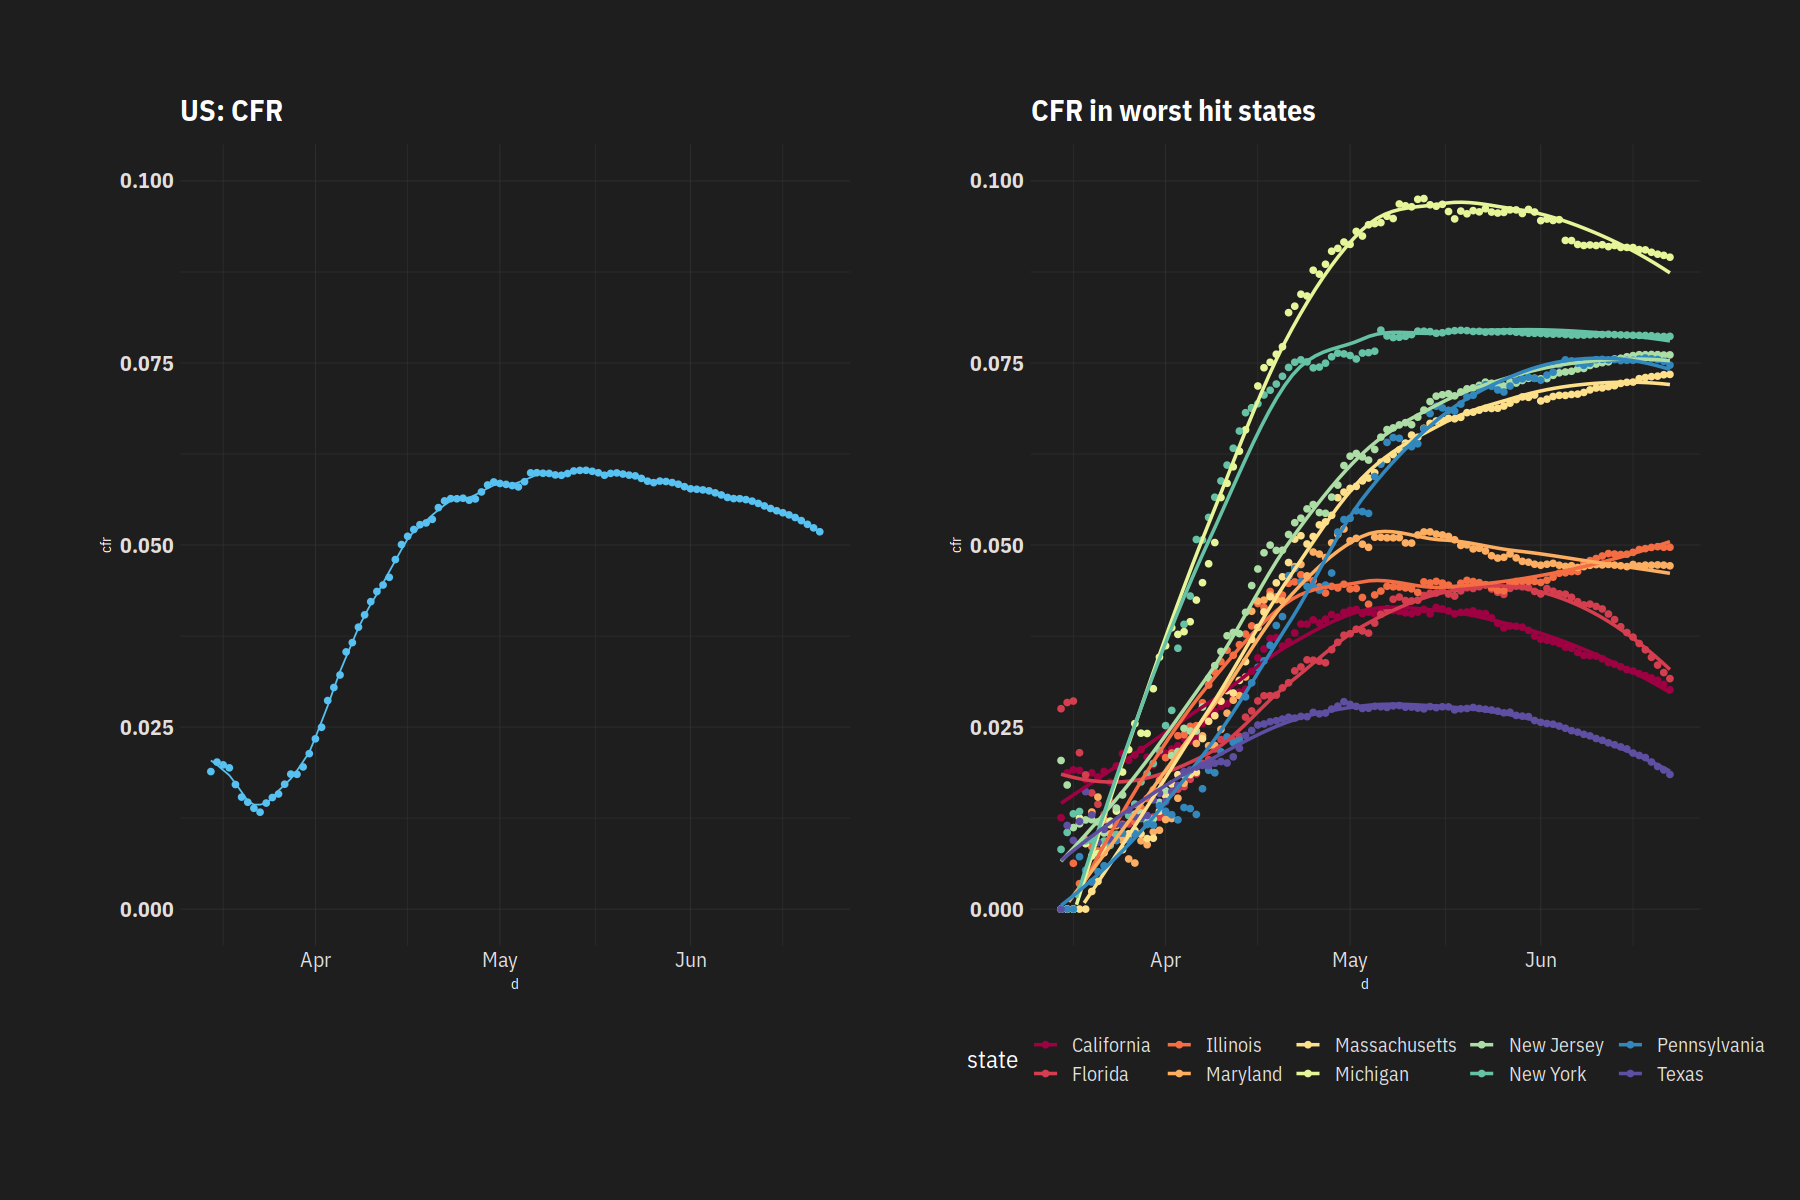

In [11]:
options(repr.plot.width = 15, repr.plot.height=10)
state_cfr = ggplot(stpan[state %in% t10$state & d >= "2020-03-15"], aes(x = d, y = cfr, group = state, colour = state)) +
    geom_point() + geom_smooth(se = F) +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("CFR in worst hit states")
nat_cfr + ylim(c(0, 0.10)) | state_cfr + ylim(c(0, 0.10))

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”


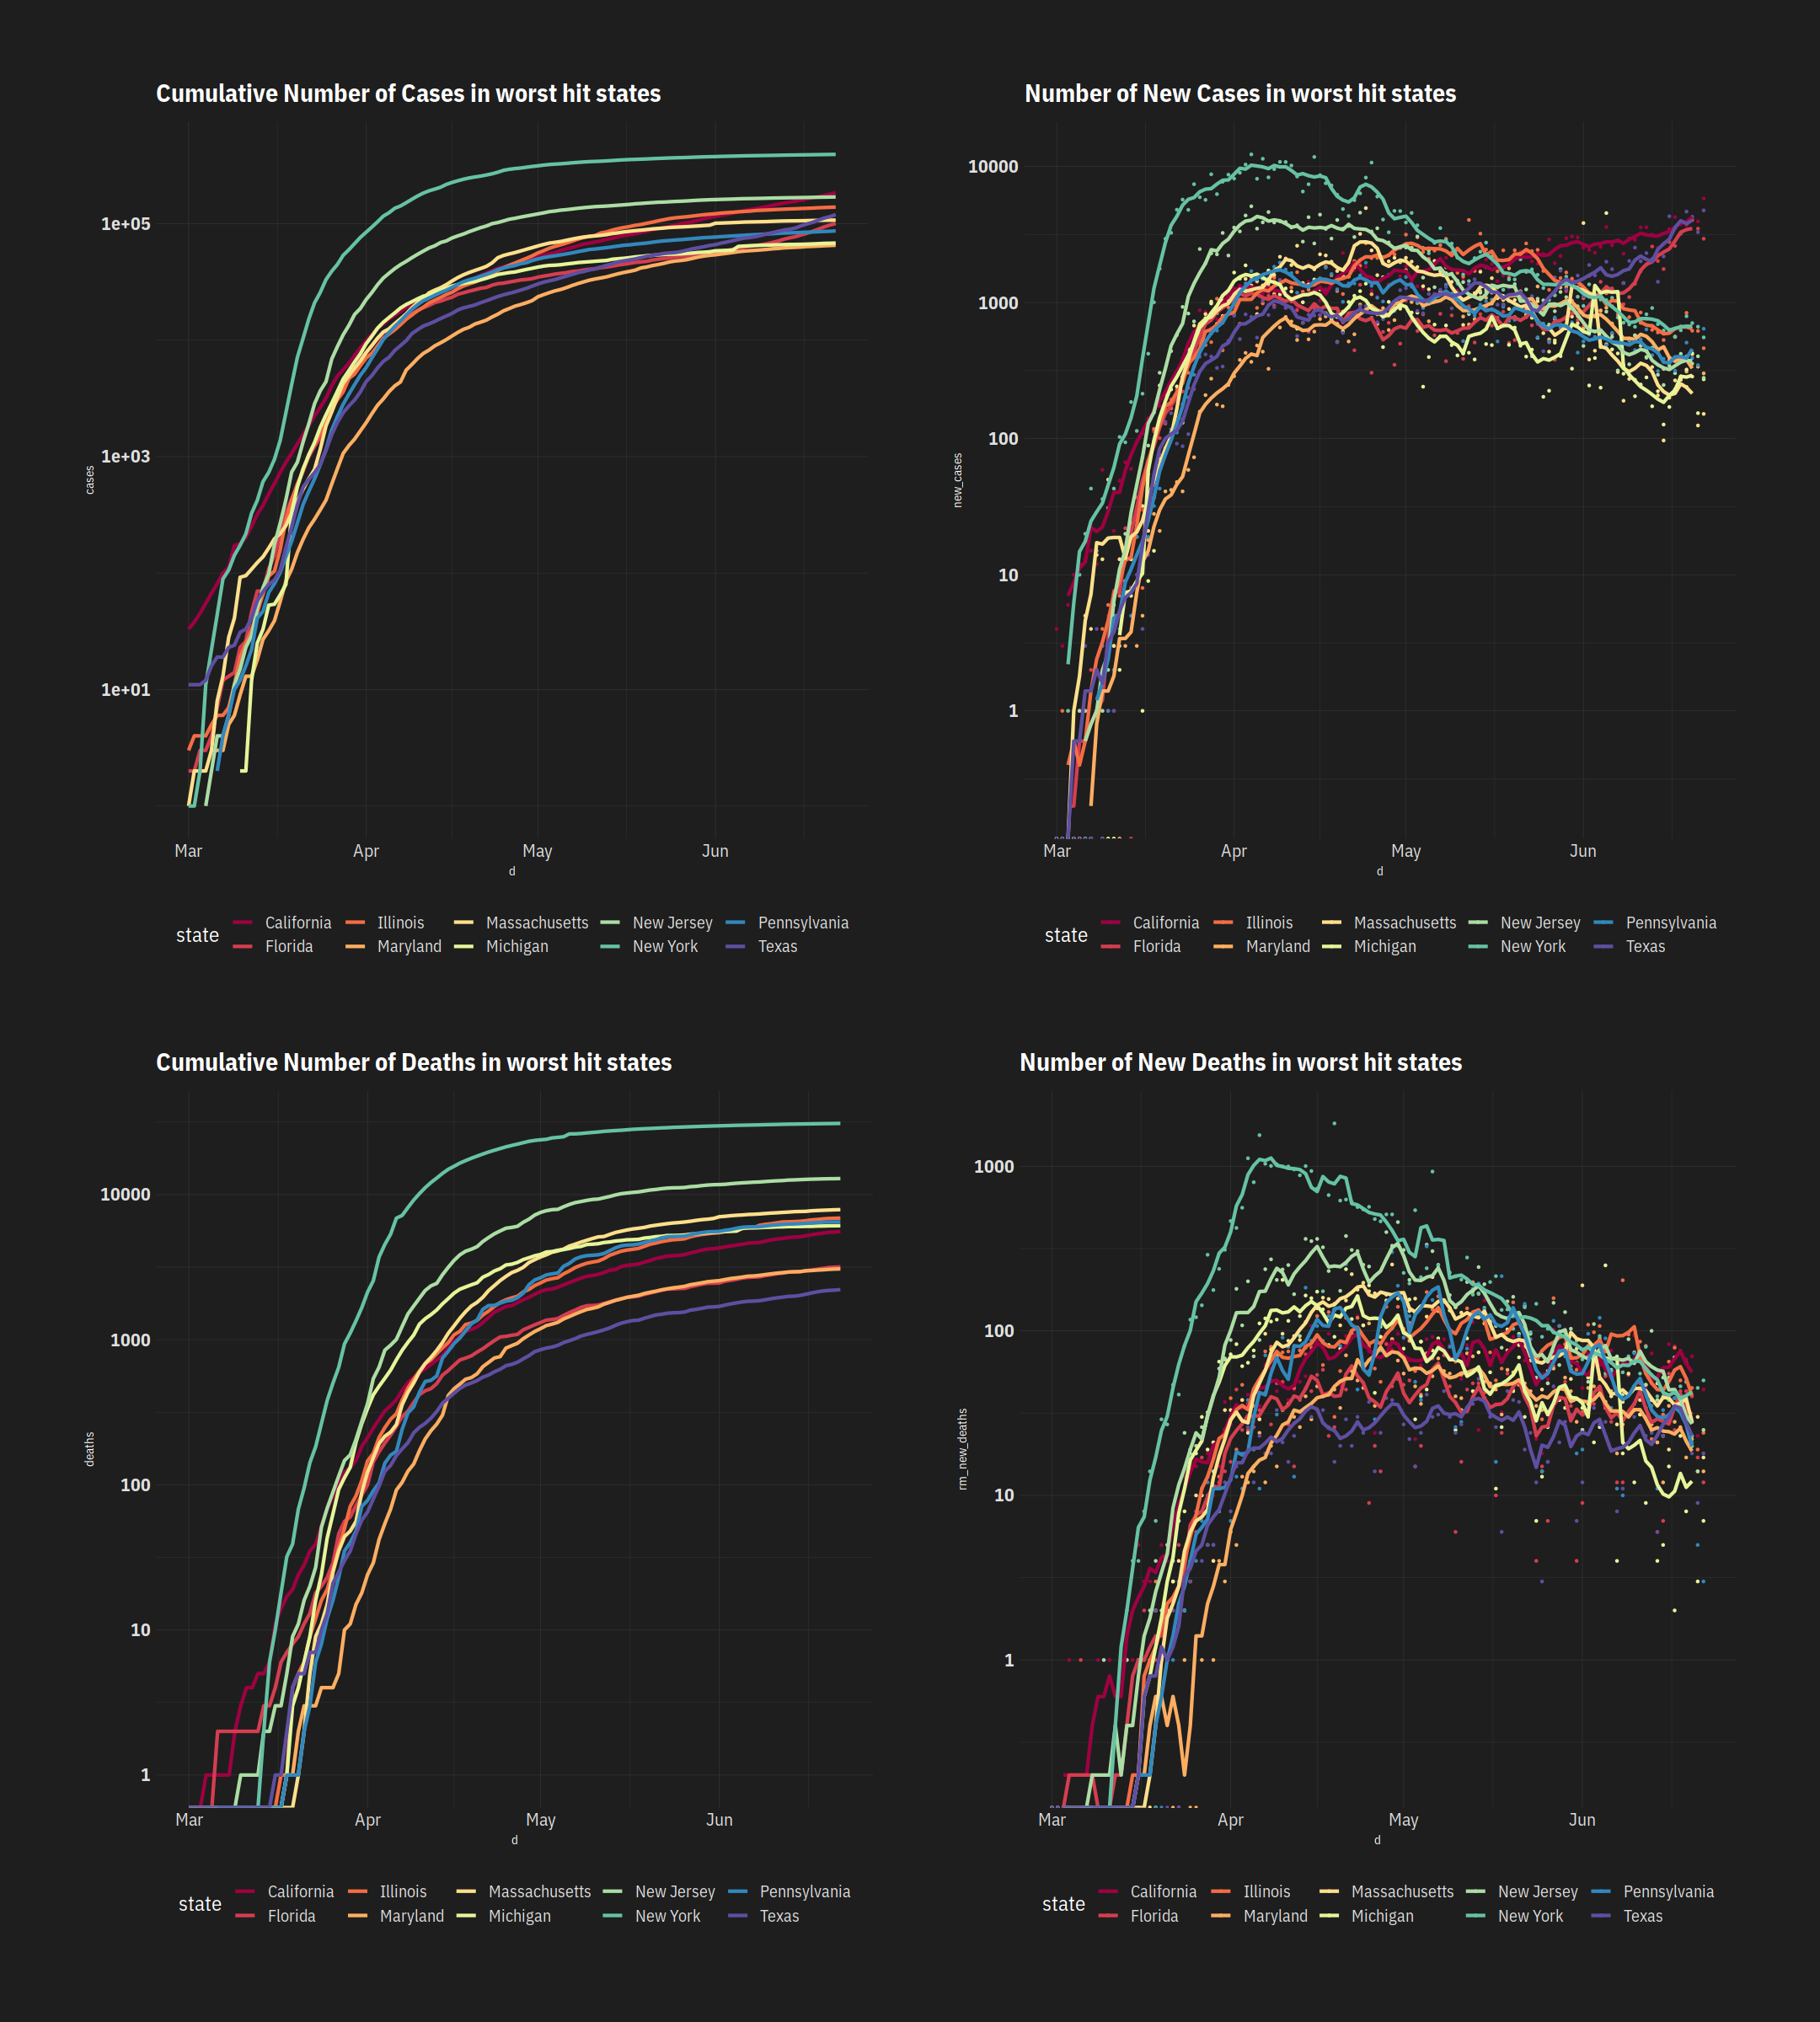

In [12]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(stpan[state %in% t10$state], aes(x = d, y = cases, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Cases in worst hit states")

p11 = ggplot(stpan[state %in% t10$state], aes(x = d, group = state, colour = state)) +
  geom_point(aes(y = new_cases), size = 0.6) +
  geom_line(aes(y = rm_new_cases), size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Cases in worst hit states")

p2 = ggplot(stpan[state %in% t10$state], aes(x = d, y = deaths, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Deaths in worst hit states")

p22 = ggplot(stpan[state %in% t10$state], aes(x = d, y = rm_new_deaths, group = state, colour = state)) +
  geom_point(aes(y = new_deaths), size = 0.6) +
  geom_line(aes(y = rm_new_deaths), size = 1.2) +
  scale_y_log10() + 
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Deaths in worst hit states")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”


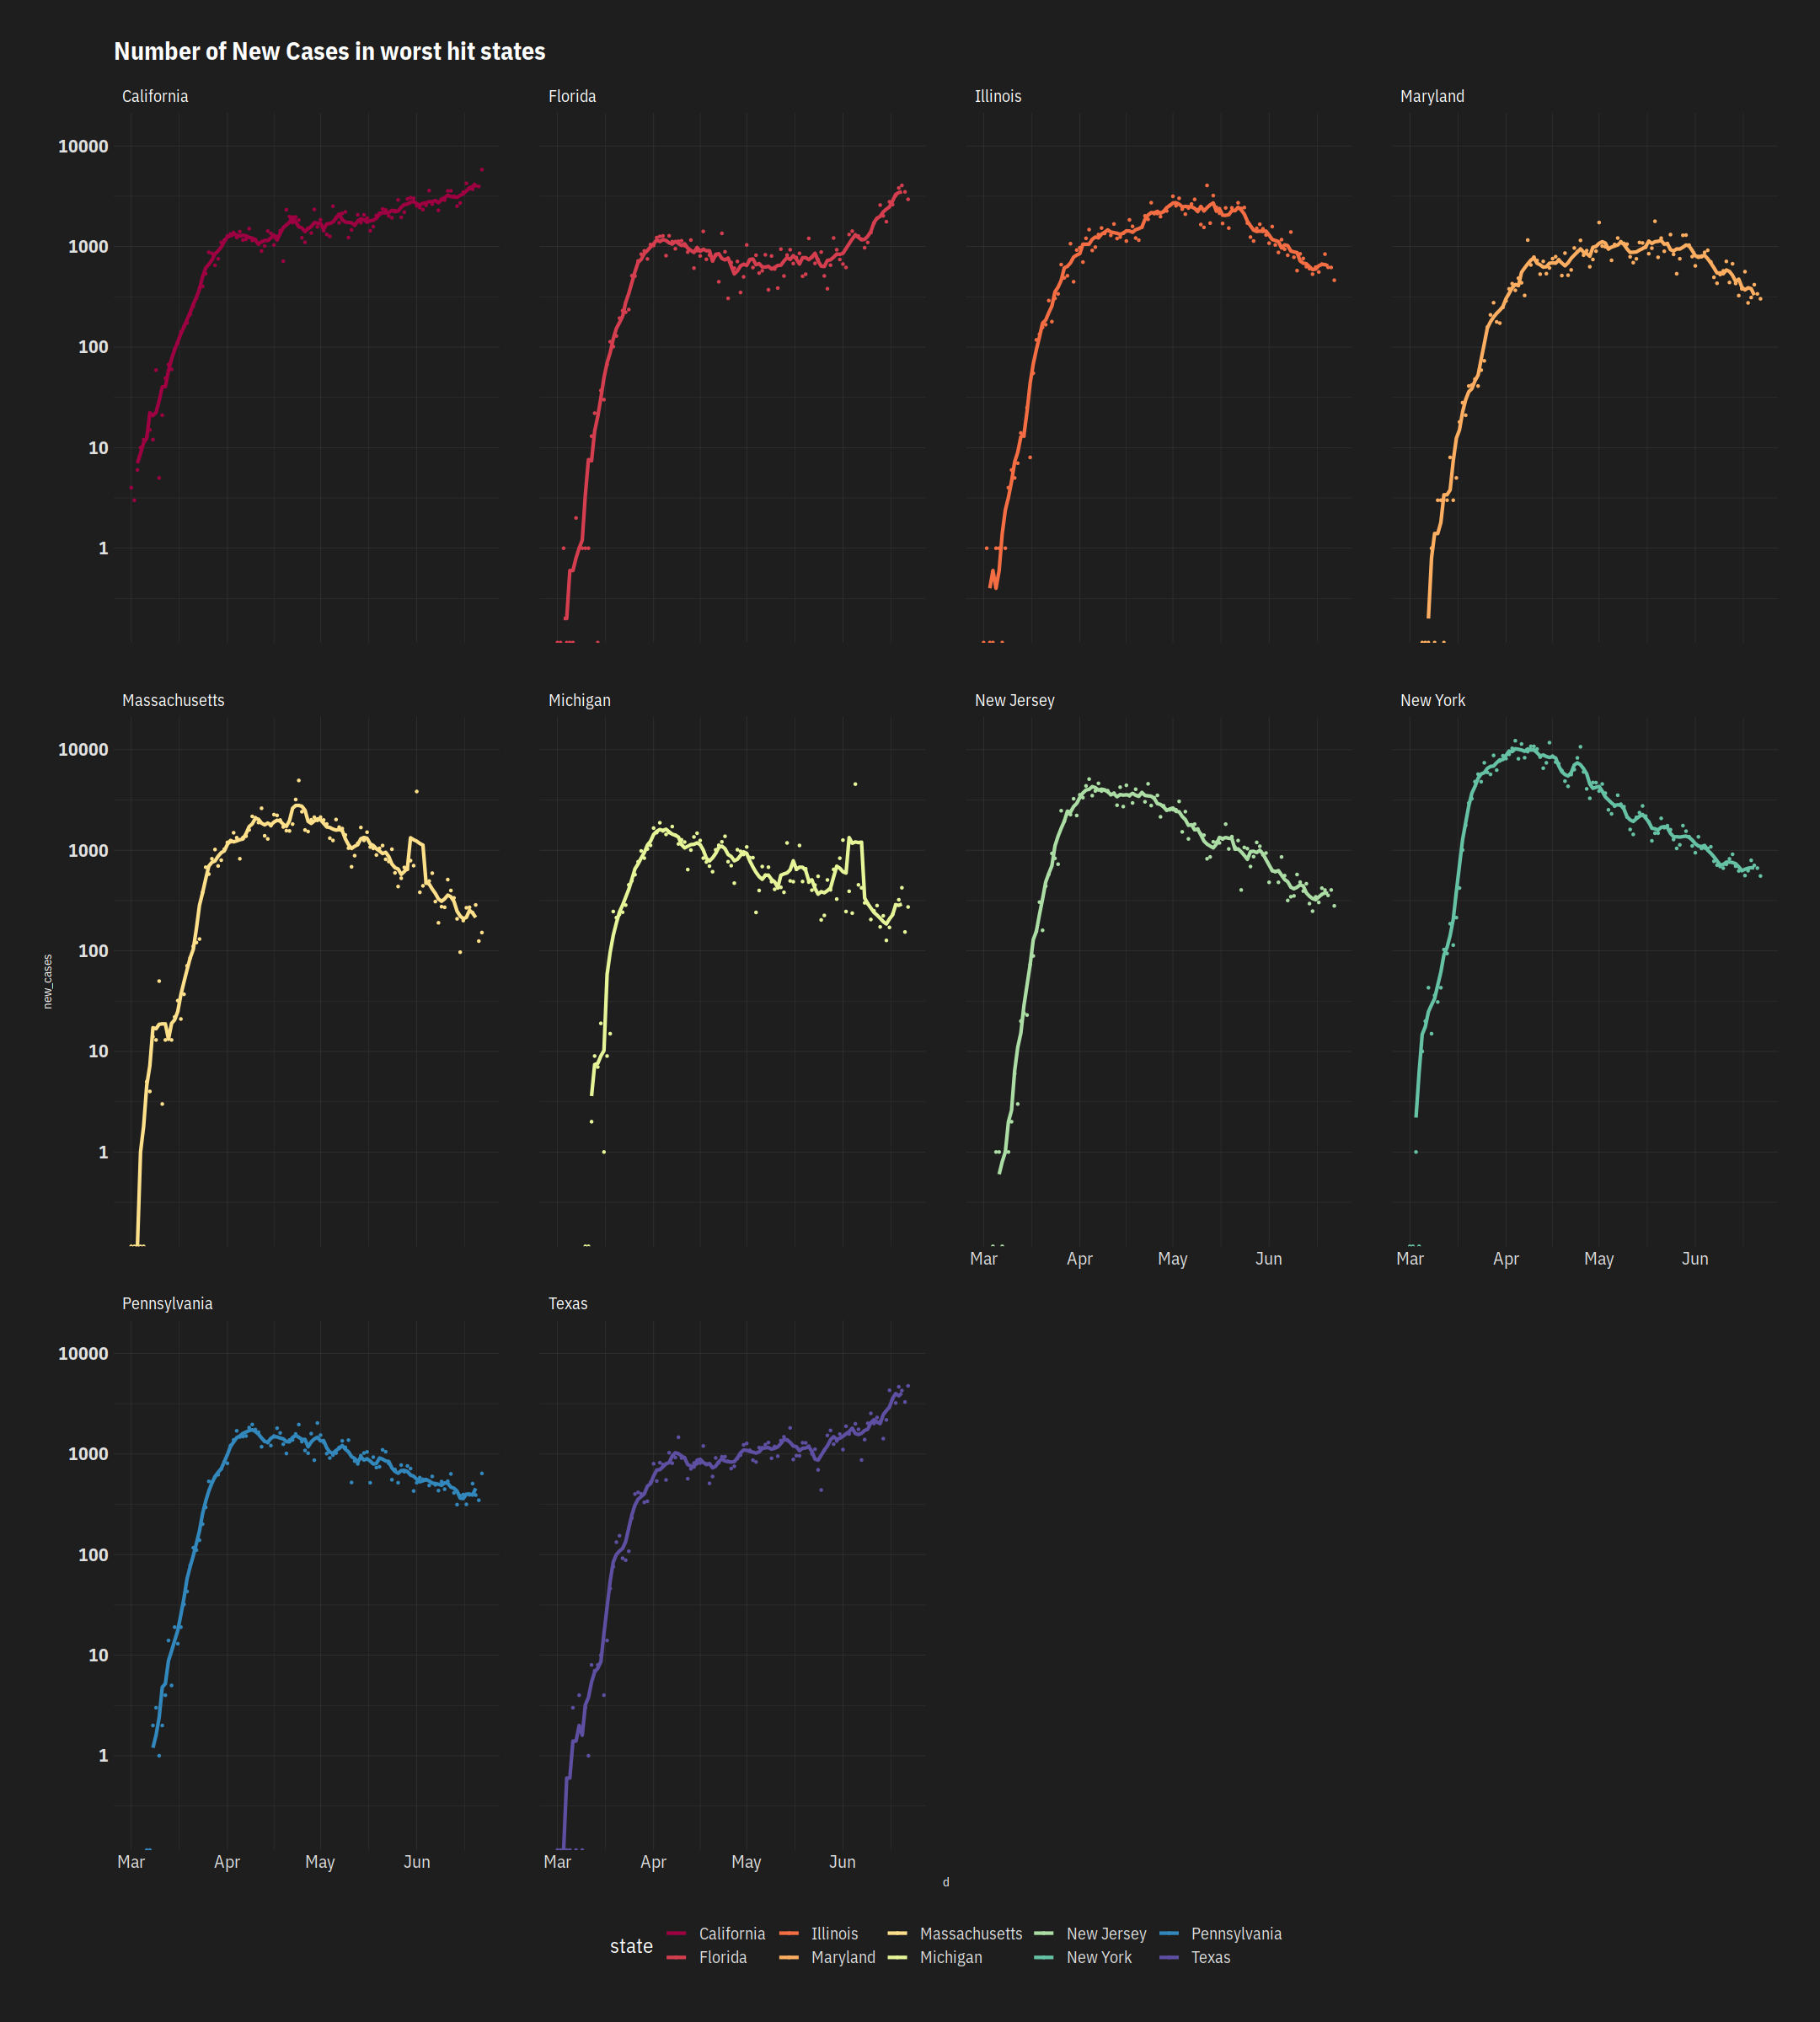

In [13]:
p11 + facet_wrap(~ state) 

+ TBD - merge in small area poverty estimates 
https://www2.census.gov/programs-surveys/saipe/datasets/2018/2018-state-and-county/est18all.xls
+ Census population data codebook
https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/co-est2019-alldata.pdf

In [14]:
county_tables = fread("https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv")
county_tables %>% glimpse
fwrite(county_tables, "data/county_popest.csv")

Rows: 3,193
Columns: 164
$ SUMLEV                <int> 40, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,…
$ REGION                <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ DIVISION              <int> 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,…
$ STATE                 <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ COUNTY                <int> 0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 2…
$ STNAME                <chr> "Alabama", "Alabama", "Alabama", "Alabama", "Al…
$ CTYNAME               <chr> "Alabama", "Autauga County", "Baldwin County", …
$ CENSUS2010POP         <int> 4779736, 54571, 182265, 27457, 22915, 57322, 10…
$ ESTIMATESBASE2010     <int> 4780125, 54597, 182265, 27455, 22915, 57322, 10…
$ POPESTIMATE2010       <int> 4785437, 54773, 183112, 27327, 22870, 57376, 10…
$ POPESTIMATE2011       <int> 4799069, 55227, 186558, 27341, 22745, 57560, 10…
$ POPESTIMATE2012       <int> 4815588, 54954, 190145, 27169, 22667, 57580, 10…
$ POPESTIMATE2013       <in

## CA: Subregions

In [15]:
bay_counties = c(
  "San Francisco", "San Mateo", "Santa Clara",
  "Alameda", "Contra Costa", "Marin"
)

socal = c("Los Angeles", "Orange", "Ventura", "San Bernadino", "Riverside",
          "Imperial", "Kern", "San Diego", "Santa Barbara", "San Luis Obispo")

ca_all = df[state == "California"]
ca_all[, metro := case_when(
    county %in% bay_counties ~ "Bay",
    county %in% socal        ~ "SoCal",
    TRUE                     ~ "Elsewhere")]
vars = c("cases", "deaths", "new_cases", "new_deaths")
ca_div = ca_all[, lapply(.SD, sum, na.rm = T), 
   by = .(metro, d), .SDcols = vars]

In [16]:
ca_div = rollmeaneR(ca_div, smoothvars = vars, grouping = 'metro')

In [17]:
kvs = c("cases", "deaths", "new_cases", "new_deaths", 'd')
cur = ca_div[order(-d), .SD[1], by = metro, .SDcols = kvs]
cur[, cfr := (deaths / cases)][]
cur[, lapply(.SD, sum, na.rm = T), .SDcols = vars]

metro,cases,deaths,new_cases,new_deaths,d,cfr
<chr>,<int>,<int>,<dbl>,<dbl>,<date>,<dbl>
Bay,18222,506,629,2,2020-06-22,0.02777
Elsewhere,31225,698,1118,10,2020-06-22,0.02235
SoCal,135173,4357,4067,32,2020-06-22,0.03223


cases,deaths,new_cases,new_deaths
<int>,<int>,<dbl>,<dbl>
184620,5561,5814,44


Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 12 row(s) containing missing values (geom_path).”


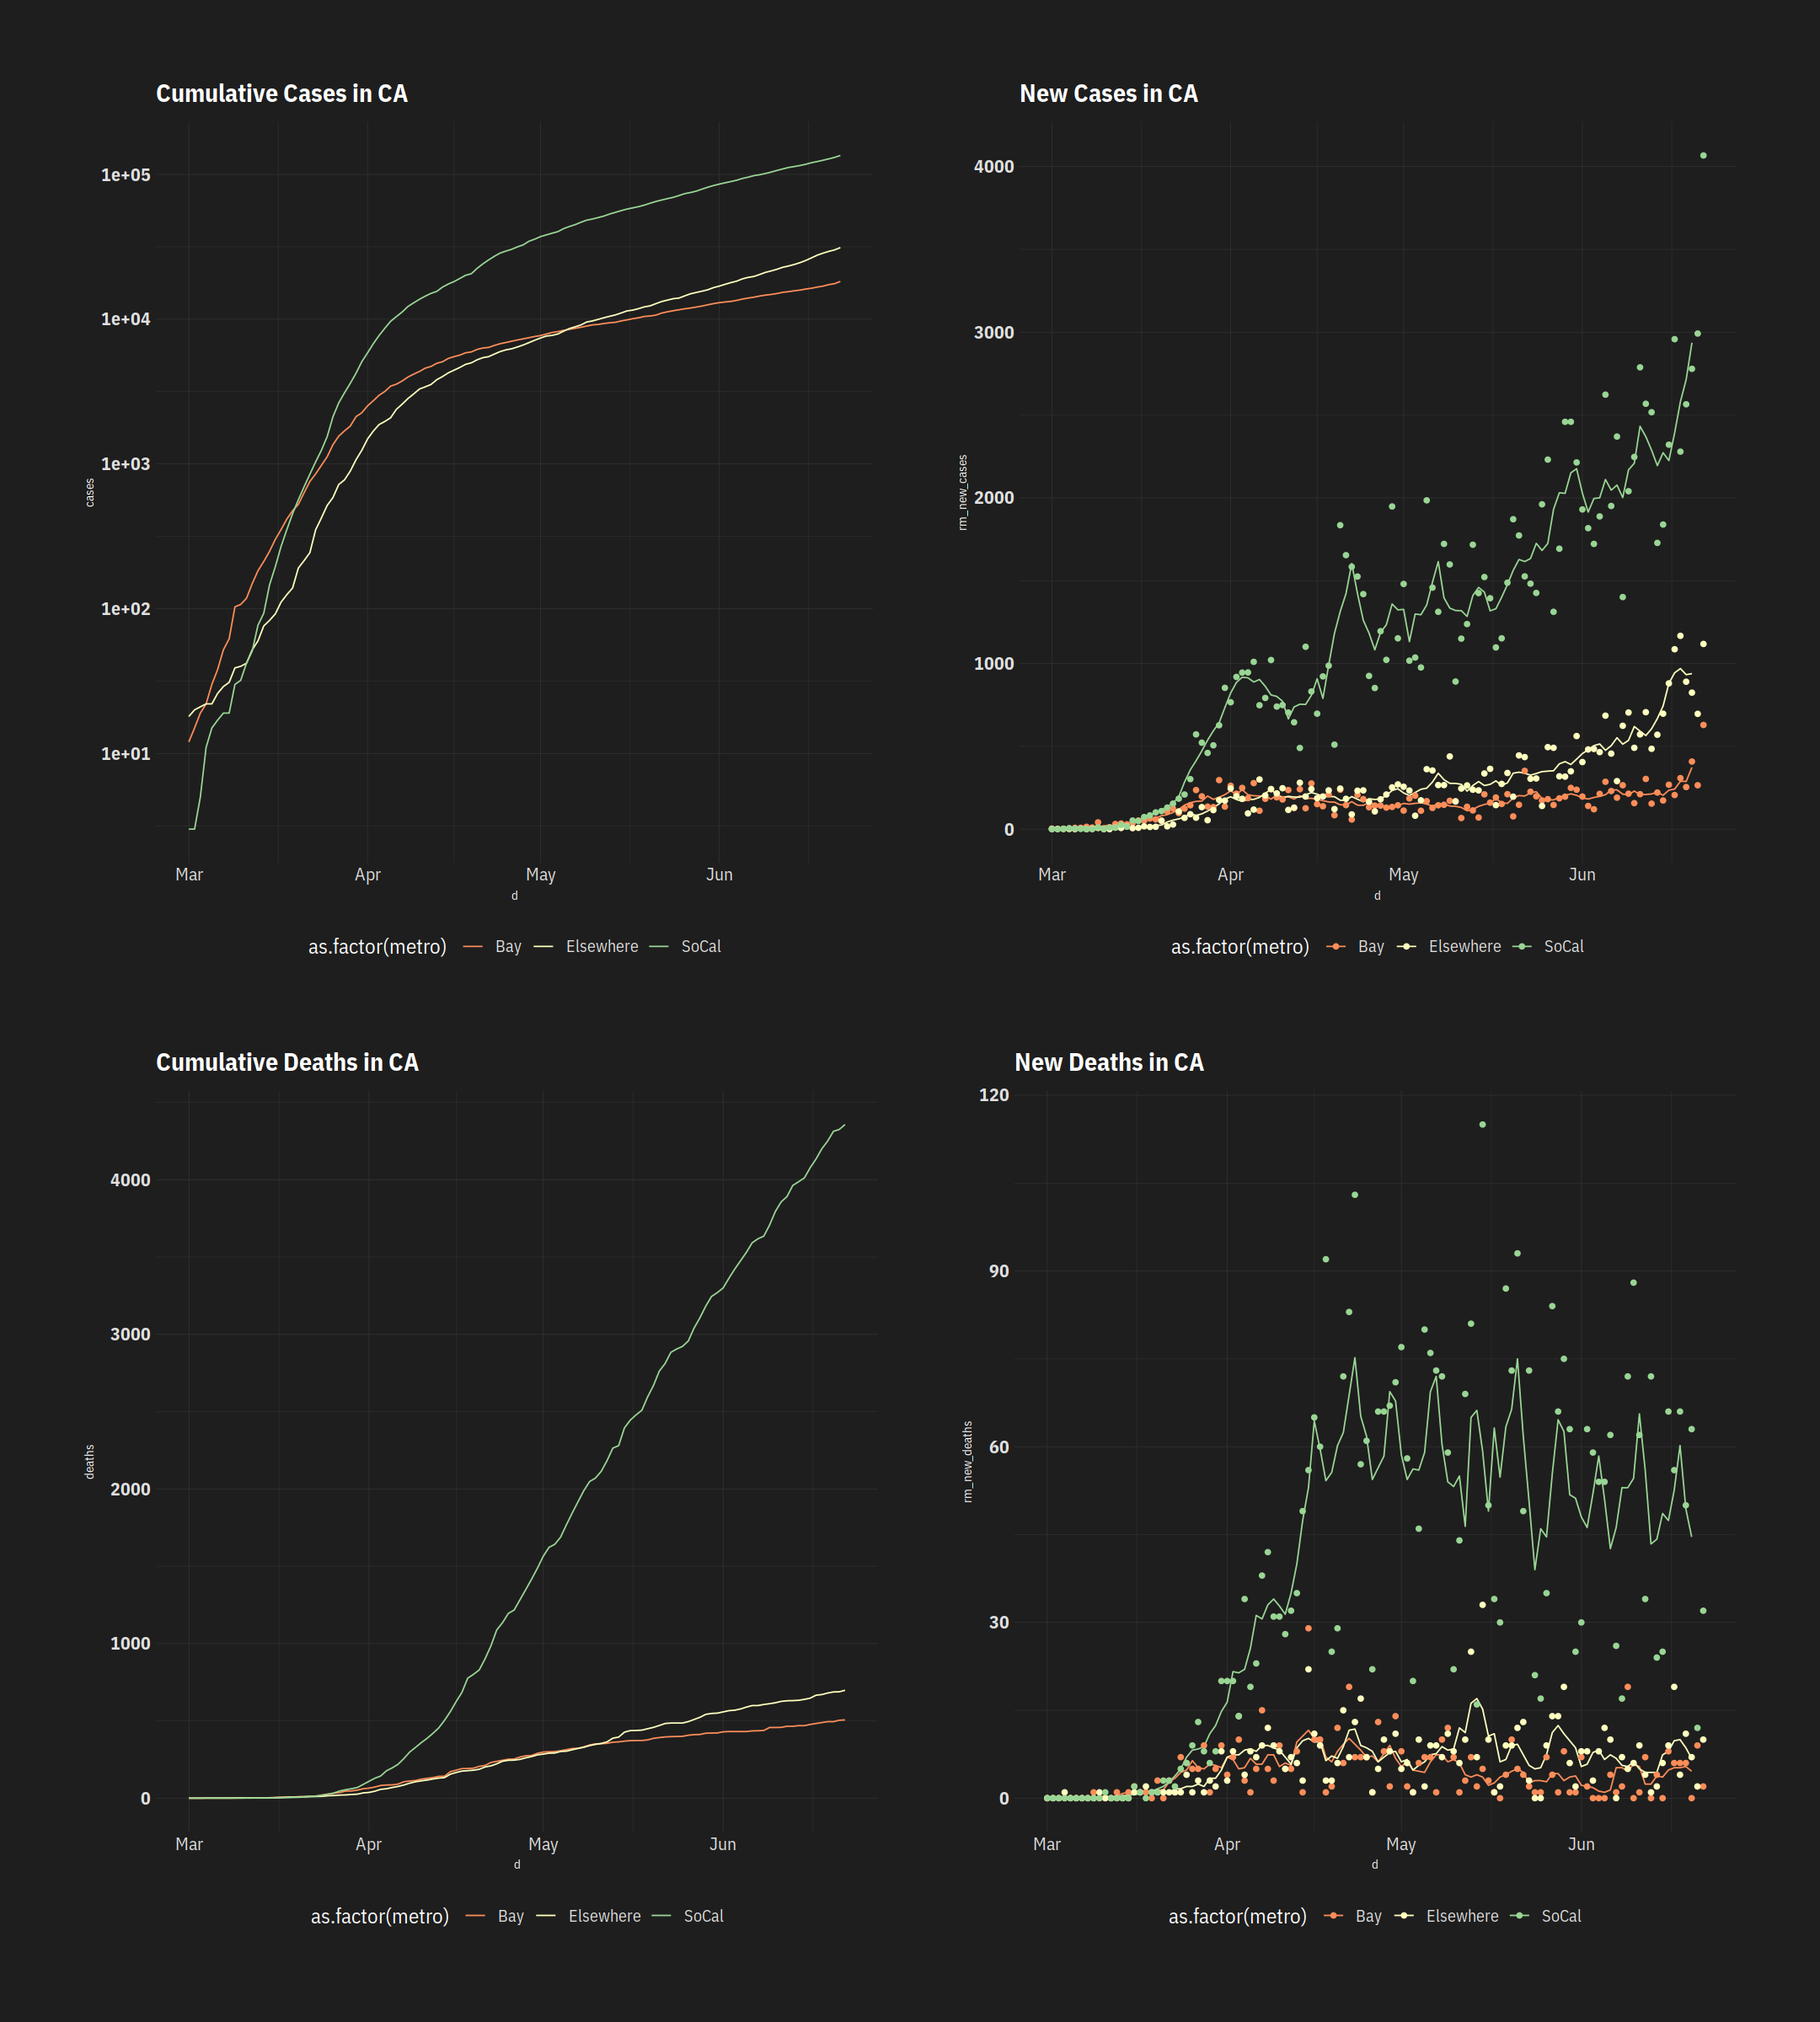

In [18]:
p1 = ggplot(ca_div, aes(x = d, y = cases, group = as.factor(metro), colour = as.factor(metro))) +
    geom_line() + scale_y_log10()+
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Cumulative Cases in CA")
p2 = ggplot(ca_div, aes(x = d,  group = as.factor(metro), colour = as.factor(metro))) +
  geom_line(aes(y = rm_new_cases)) +
  geom_point(aes(y = new_cases)) +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("New Cases in CA")

p3 = ggplot(ca_div, aes(x = d, y = deaths, group = as.factor(metro), colour = as.factor(metro))) +
  geom_line() +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Cumulative Deaths in CA")

p4 = ggplot(ca_div, aes(x = d, y = rm_new_deaths, group = as.factor(metro), colour = as.factor(metro))) +
  geom_line(aes(y = rm_new_deaths)) +
  geom_point(aes(y = new_deaths)) +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("New Deaths in CA")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p2) / (p3 | p4)

## Counties within the Bay Area

In [19]:
bayrea_mar = rollmeaneR(df[county %in% bay_counties & state == "California" & d>= "2020-03-01"])
bayrea_mar[, cfr := deaths/cases]
bayrea_mar[d == max(d)]

date,county,state,fips,cases,deaths,d,cfr,new_cases,new_deaths,rm_cases,rm_deaths,rm_new_cases,rm_new_deaths
<chr>,<chr>,<chr>,<int>,<int>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-06-22,Alameda,California,6001,5028,120,2020-06-22,0.02387,202,1,NA,NA,NA,NA
2020-06-22,Contra Costa,California,6013,2369,62,2020-06-22,0.02617,75,0,NA,NA,NA,NA
2020-06-22,Marin,California,6041,1250,18,2020-06-22,0.01440,140,0,NA,NA,NA,NA
2020-06-22,San Francisco,California,6075,3188,48,2020-06-22,0.01506,127,1,NA,NA,NA,NA
2020-06-22,San Mateo,California,6081,2781,103,2020-06-22,0.03704,26,0,NA,NA,NA,NA
2020-06-22,Santa Clara,California,6085,3606,155,2020-06-22,0.04298,59,0,NA,NA,NA,NA


### Cases

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


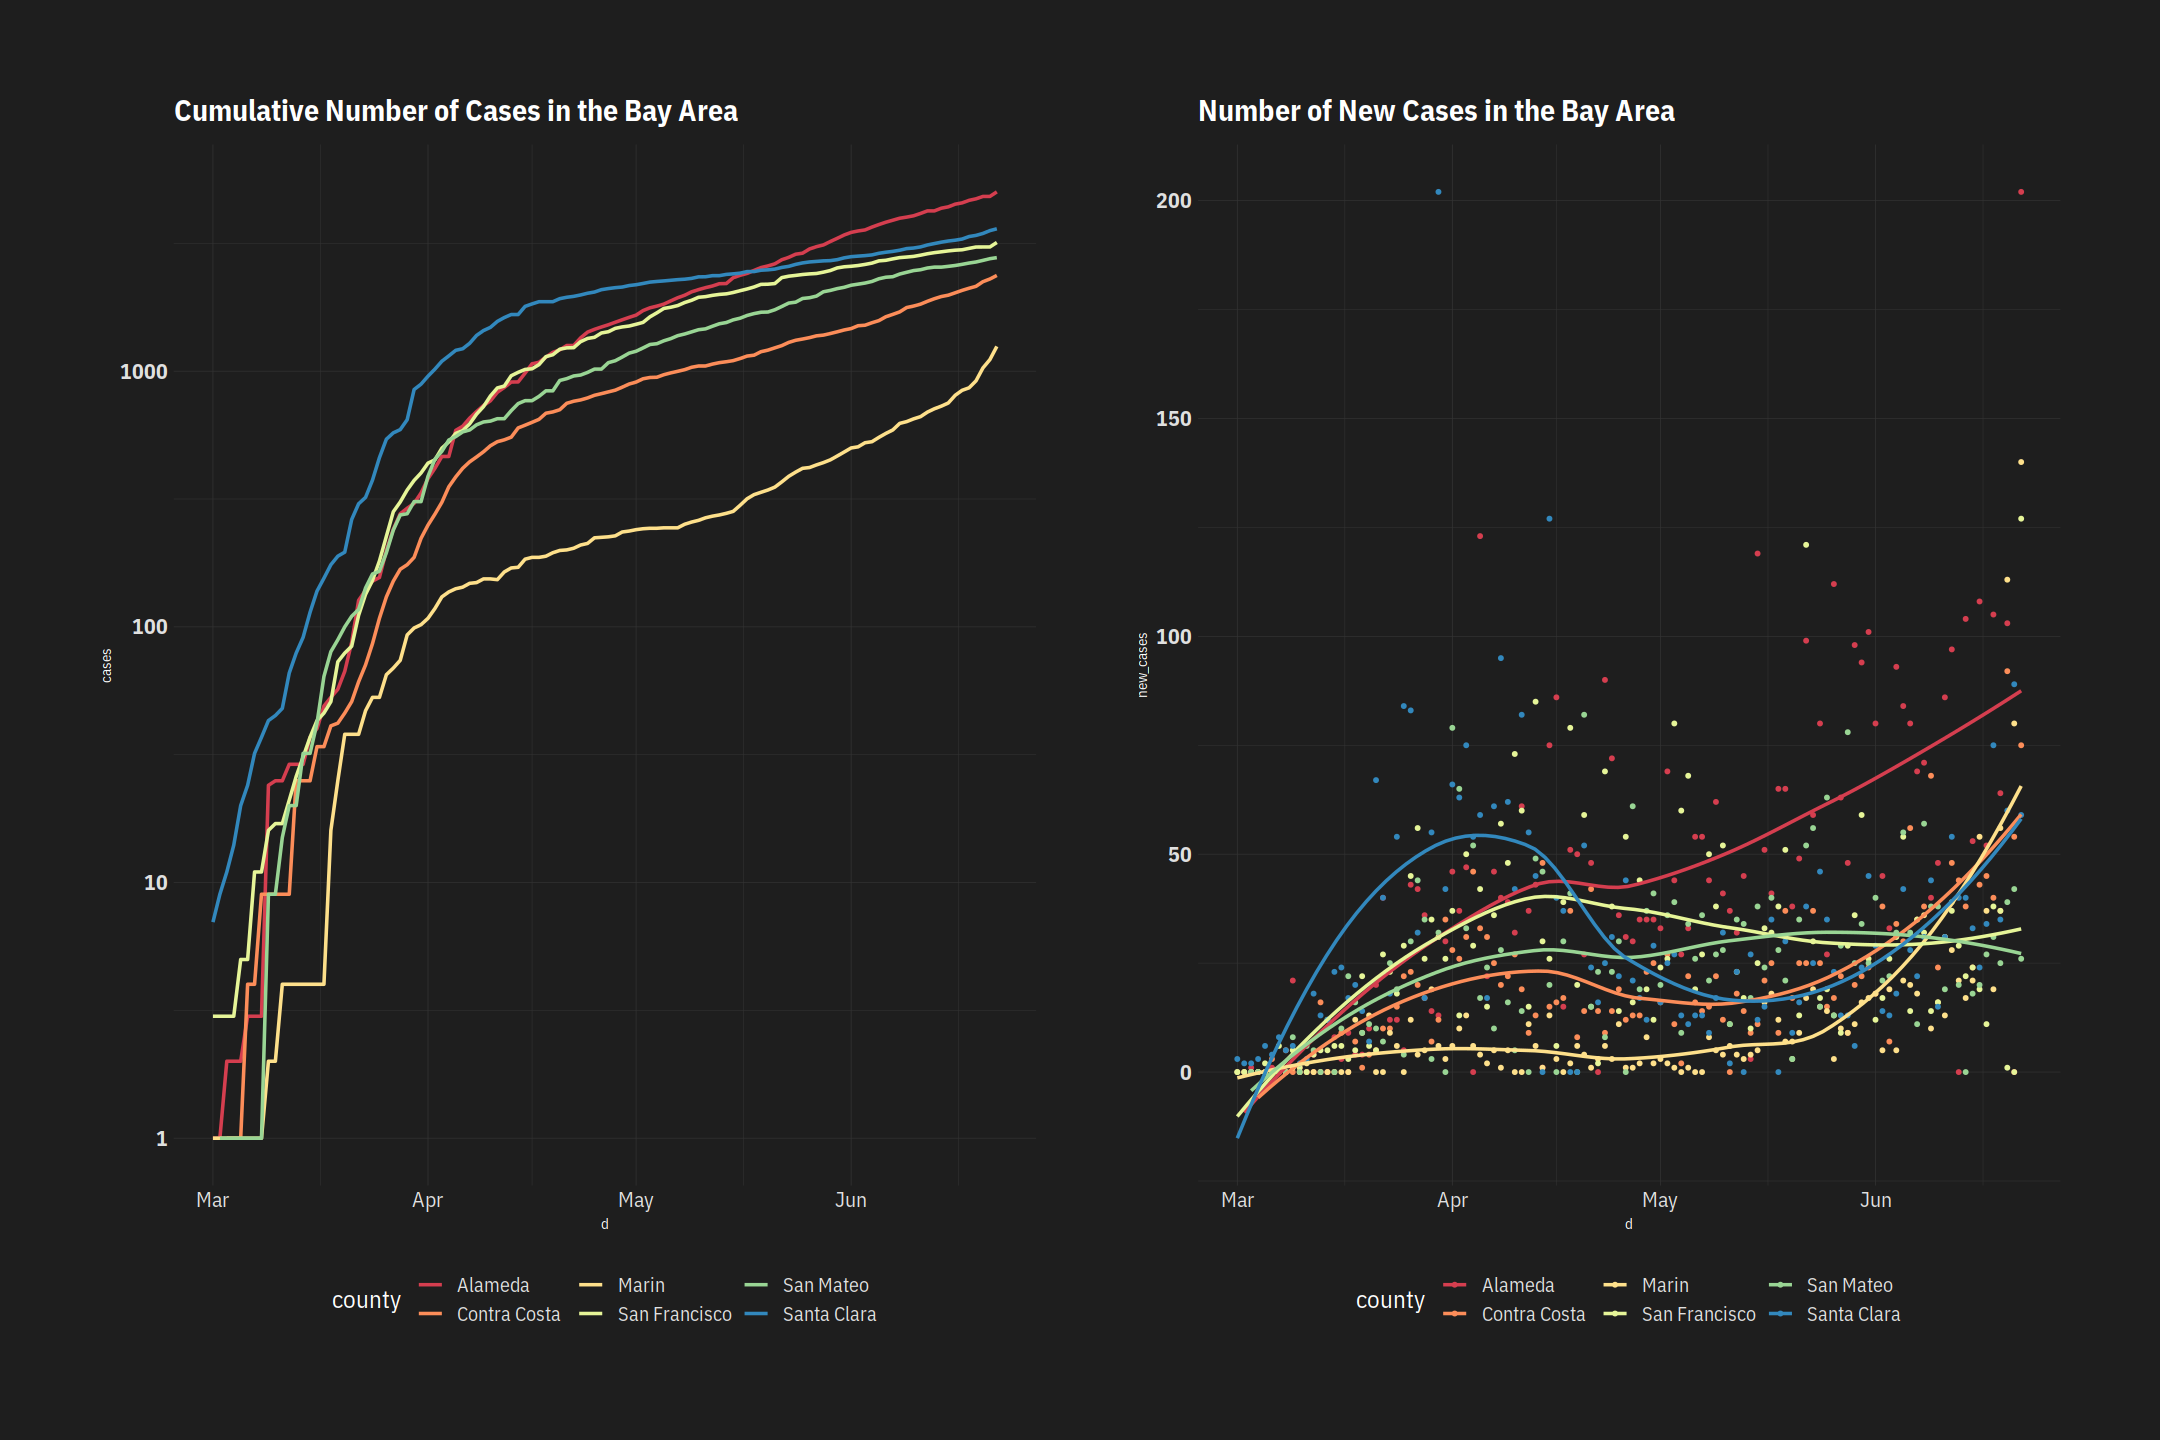

In [20]:
p1 = ggplot(bayrea_mar, aes(x = d, y = cases, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_y_log10() +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Cases in the Bay Area")

p2 = ggplot(bayrea_mar, aes(x = d, y = new_cases, group = county, colour = county)) +
  geom_point(size = 1) +
    geom_smooth(se = F) +
    scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Number of New Cases in the Bay Area")
options(repr.plot.width = 18, repr.plot.height=12)
(p1 | p2)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


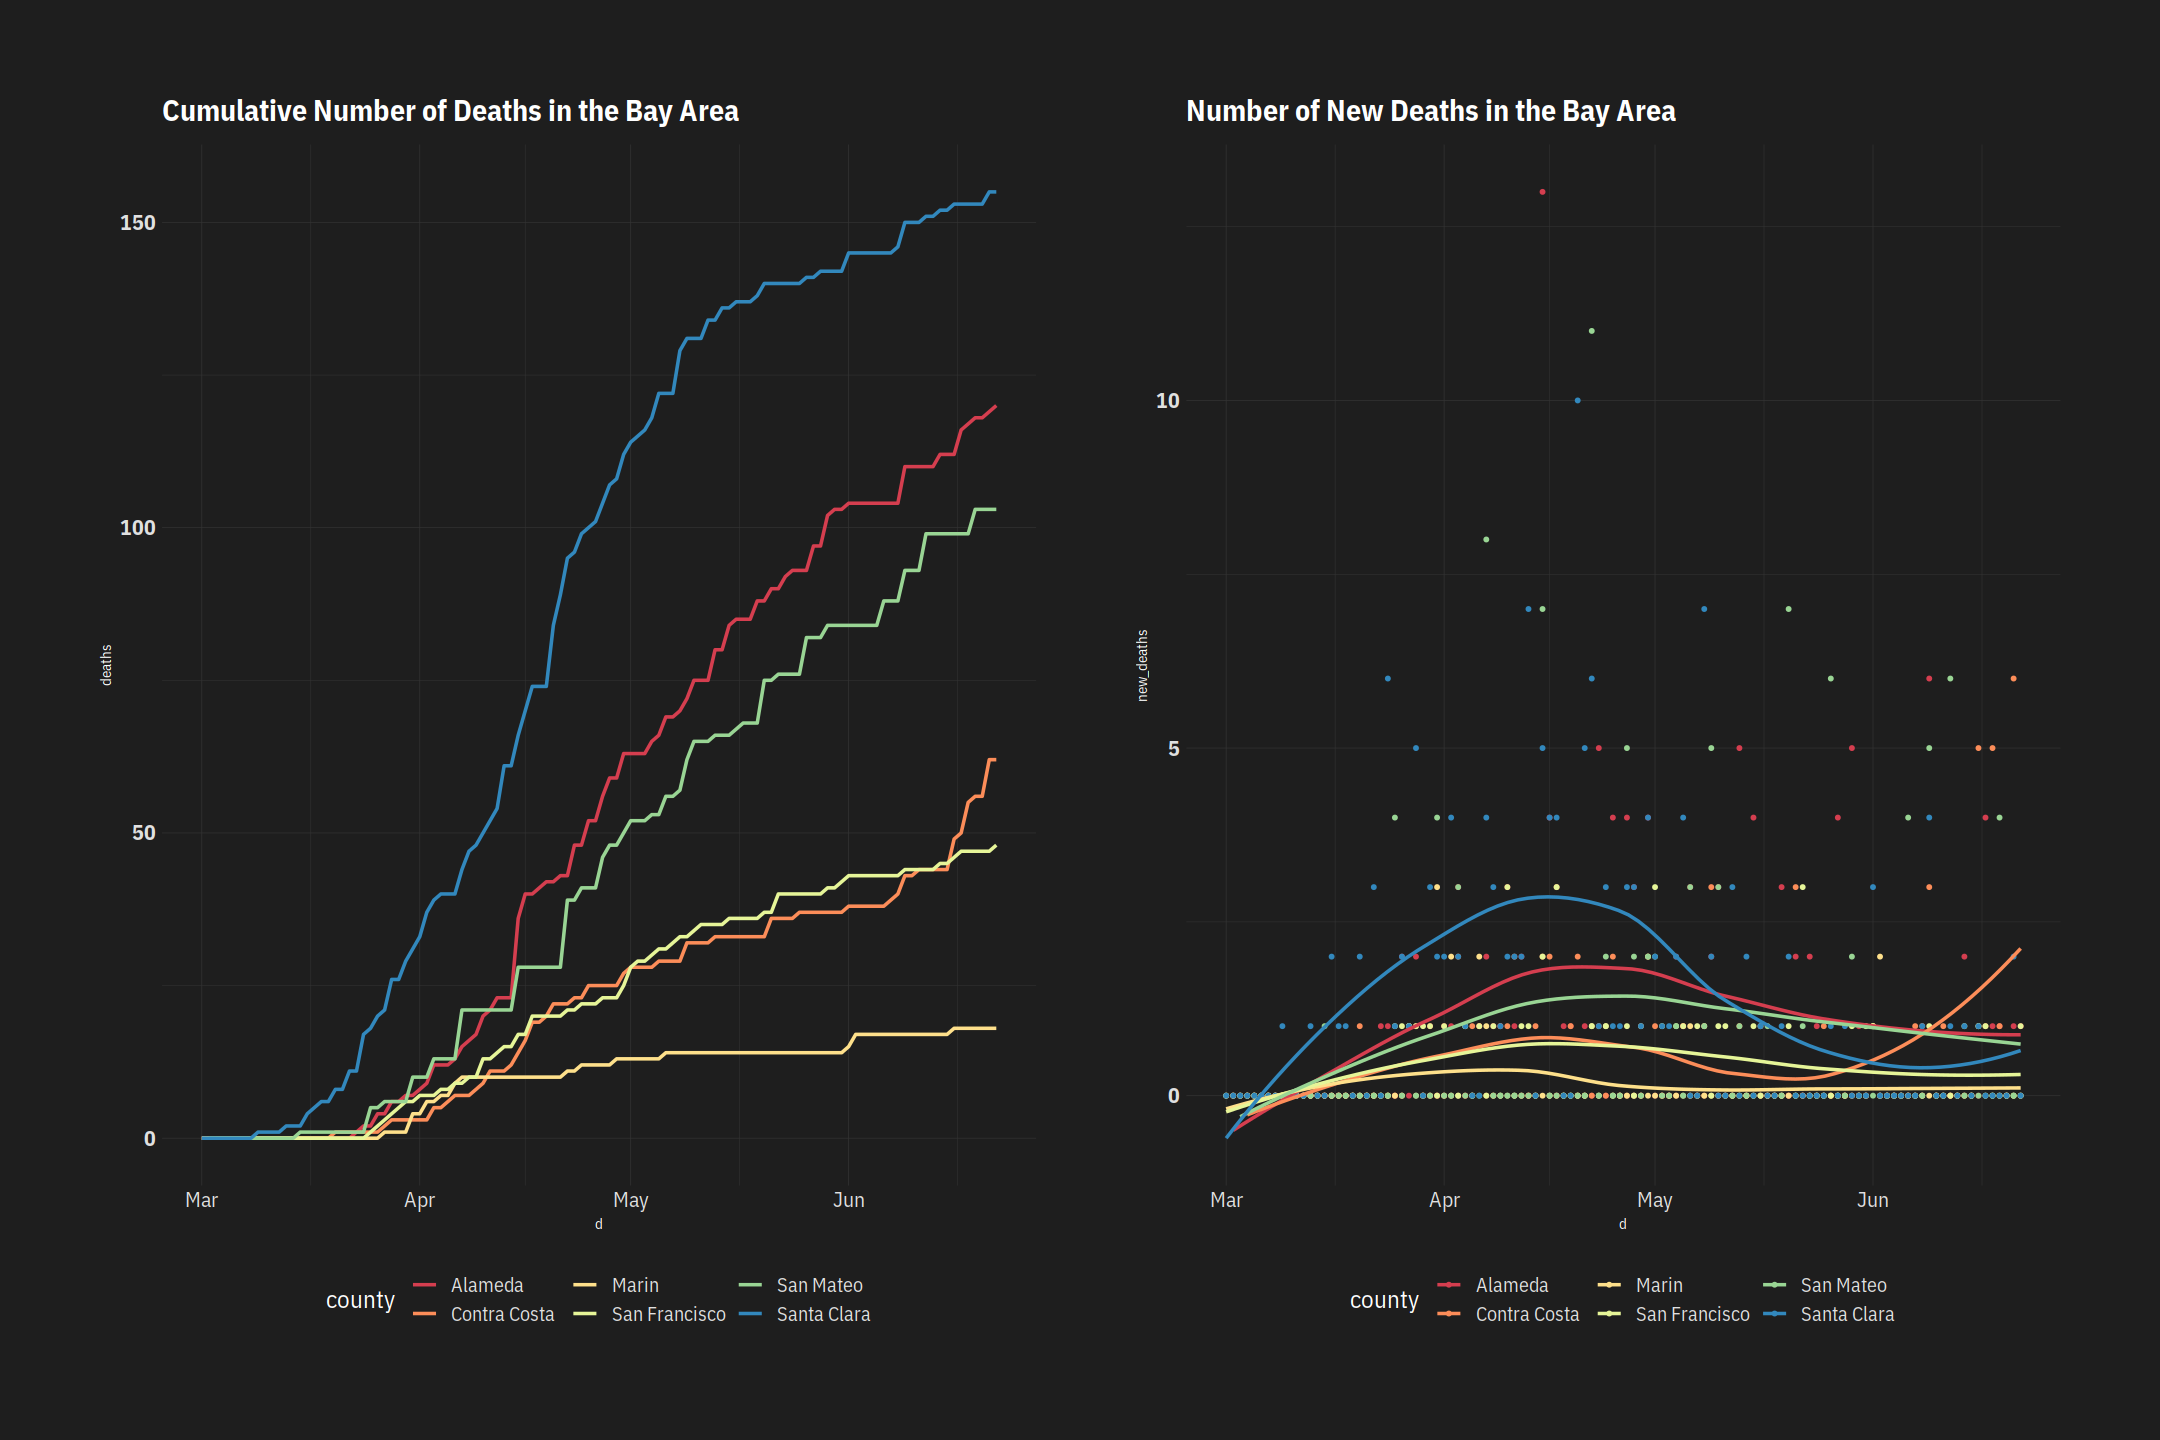

In [21]:
p1 = ggplot(bayrea_mar, aes(x = d, y = deaths, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Deaths in the Bay Area")
p2 = ggplot(bayrea_mar, aes(x = d, y = new_deaths, group = county, colour = county)) +
  geom_point(aes(y = new_deaths), size = 1) +
#   geom_line(size = 1) +
  geom_smooth(se = F) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Number of New Deaths in the Bay Area")
(p1 | p2)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



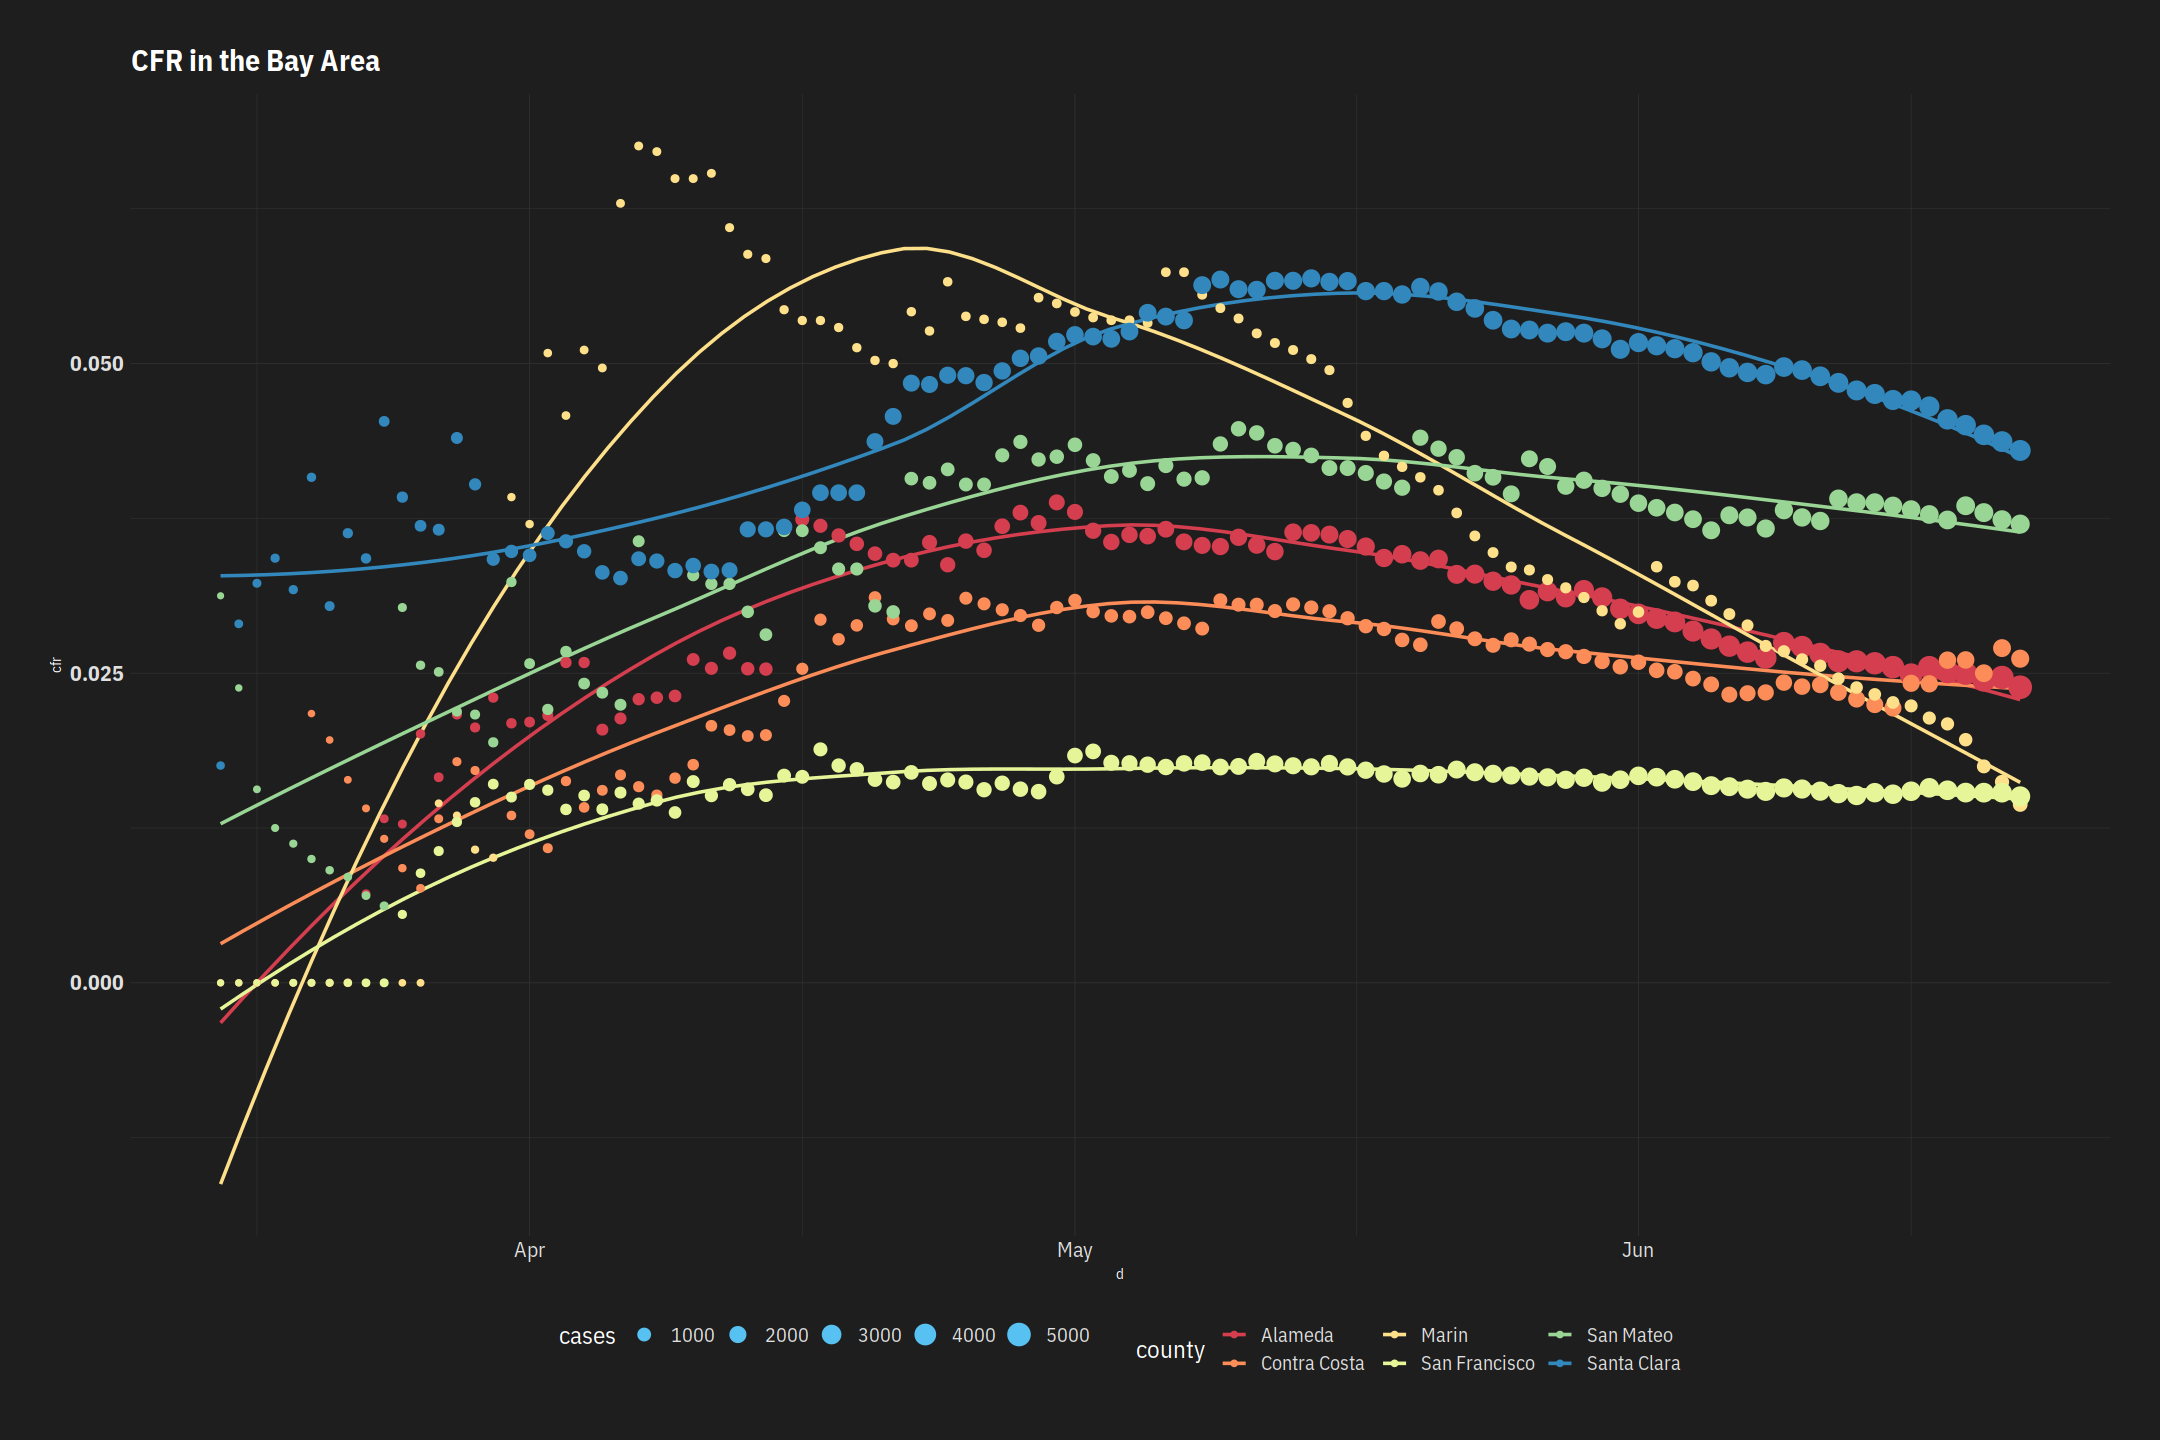

In [22]:
(cfrp = ggplot(bayrea_mar[d >= "2020-03-15"], aes(x = d, y = cfr, group = county, colour = county )) +
  geom_smooth(se = F) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("CFR in the Bay Area")
) + geom_point(aes(size = cases))